In [1]:
import types
import pandas as pd
from ibm_botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_d78d64b47cbc42798f929e203df42582 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='1R0XfMSpYMRLtiIJFQm3igvZfTvpz0iU7cGnqTG4au-1',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_d78d64b47cbc42798f929e203df42582.get_object(Bucket='default-donotdelete-pr-zfs2ic36wlwaip',Key='DCOILBRENTEU.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()



,DATE,DCOILBRENTEU
0,1989-01-03,16.40
1,1989-01-04,16.53
2,1989-01-05,16.58
3,1989-01-06,16.85
4,1989-01-09,17.00


Data Source

U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, January 10, 2018.

In [2]:
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != "."]
print df_data_1.shape

(7609, 2)


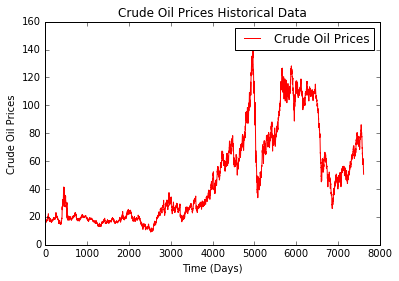

In [4]:
import matplotlib.pyplot as plt
df_data_1_plot = df_data_1.iloc[:,1:2].values
# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [5]:
#import packages
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.


In [6]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 120
timesteps = 30

In [7]:
length = len(df_data_1)
print length

#test set will be 10% of entire data set  
length *= 1 - 0.1
print length

7609
6848.1


In [8]:
#get the length of training data set 
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print x
    return (max(train_length_values))

In [9]:
length = get_train_length(df_data_1, batch_size, 0.1)
print length

6784
6784


In [10]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.iloc[:,1:2].values
training_set.shape

(6844, 1)

In [11]:
# Feature Scaling i.e we scale each and every value between 0 and 1 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(6844, 1)

In [12]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print length + timesteps
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print len(X_train)
print len (y_train)
print np.array(X_train).shape
print np.array(y_train).shape

6814
6784
6784
(6784, 30)
(6784, 30)


In [13]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print X_train.shape
print y_train.shape

(6784, 30, 1)
(6784, 30, 1)


In [14]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [15]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 1st LSTM Layer 
parameters = 4 * 10 * (1 + 10 + 1)
print parameters

480


In [17]:
# 2nd LSTM Layer 
parameters = 4 * 10 * (10 + 10 + 1)
print parameters

840


In [18]:
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 0
Epoch 1/1
6784/6784 [==============================] - 5s - loss: 0.0743     
Epoch: 1
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0751     
Epoch: 2
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0661     
Epoch: 3
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0660     - ETA: 0s - loss: 0
Epoch: 4
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0653     
Epoch: 5
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0632     
Epoch: 6
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0602     
Epoch: 7
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0569     
Epoch: 8
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0540     
Epoch: 9
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0522     
Epoch: 10
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0508     
Epoch: 11
Epoch 1/1
678

6784/6784 [==============================] - 2s - loss: 0.0377     
Epoch: 94
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0375     
Epoch: 95
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0375     
Epoch: 96
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0374     
Epoch: 97
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0374     
Epoch: 98
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0373     
Epoch: 99
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0373     
Epoch: 100
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0372     
Epoch: 101
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0372     
Epoch: 102
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0371     
Epoch: 103
Epoch 1/1
6784/6784 [==============================] - 2s - loss: 0.0371     - ET
Epoch: 104
Epoch 1/1
6784/6784 [============

In [19]:
!pwd
!ls models/*.h5

/gpfs/fs01/user/sba4-025109b8cbf0b6-2883b35da29d/notebook/work
models/my_model_with_mae_30_ts.h5


In [20]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print x
    return (max(test_length_values))

In [21]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print testset_length

7420
7484
7548
7548
704


In [22]:
print upper_train, upper_test, len(df_data_1)

6844 7608 7609


In [23]:
# construct test set

#subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [24]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print predicted_bcg_values_test_mae.shape

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print predicted_bcg_values_test_mae.shape
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print y_test.shape

(704, 30, 1)
(704, 30)
(674, 1)


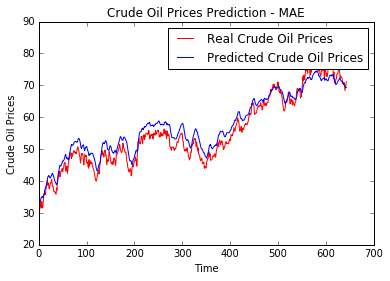

In [25]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)], color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [26]:

import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

2.97348277151


In [27]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

2.6177178502527085


In [28]:
import h5py
regressor_mae.save(filepath="models/my_model_with_mae_30_ts.h5")